In [55]:
import pandas as pd

bitcoin_news = pd.read_csv(r"../crypto_news/bitcoin.csv")
coinbase_news = pd.read_csv(r"../crypto_news/coinbase.csv")

bitcoin_news.head()

,Date,ID,News
0,2021-04-14 01:15:37,33799410.0,bitcoin pushes to fresh record high after bre...
1,2021-04-14 07:27:48,33805259.0,bitcoin is not at its bull market top if meas...
2,2021-04-14 08:21:39,33807018.0,gold futures edge lower on wednesday as marke...
3,2021-04-14 08:31:39,33807426.0,open interest on bitcoin futures across the l...
4,2021-04-14 09:26:18,33809664.0,btbt stock is gaining on wednesday ahead of t...


In [56]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="mr8488/distilroberta-finetuned-financial-news-sentiment-analysis-v2",
)

In [57]:
from transformers import AutoTokenizer

# trunctatind news to max allowed tokens
tokenizer = AutoTokenizer.from_pretrained(
    "mr8488/distilroberta-finetuned-financial-news-sentiment-analysis-v2"
)

bitcoin_news["News"] = bitcoin_news["News"].apply(
    lambda x: tokenizer(x, truncation=True, max_length=512)["input_ids"]
)
bitcoin_news["News"] = bitcoin_news["News"].apply(lambda x: tokenizer.decode(x))

coinbase_news["News"] = coinbase_news["News"].apply(
    lambda x: tokenizer(x, truncation=True, max_length=512)["input_ids"]
)
coinbase_news["News"] = coinbase_news["News"].apply(lambda x: tokenizer.decode(x))

In [58]:
# making a function to return setiement
def get_bert_sentiment(news_description):
    try:
        sent = pipe(news_description)
        label = sent[0]["label"]
        score = sent[0]["score"]

        # attempt at making a consolidated label
        if label == "positive":
            combined_label = 1
        elif label == "negative":
            combined_label = -1
        else:
            combined_label = 0

        return pd.Series([label, score, combined_label])

    except IndexError:
        return pd.Series(["BAD Data", 0, 0])


bitcoin_news[["label", "score", "combined_label"]] = bitcoin_news["News"].apply(
    lambda x: get_bert_sentiment(x)
)
coinbase_news[["label", "score", "combined_label"]] = coinbase_news["News"].apply(
    lambda x: get_bert_sentiment(x)
)

bitcoin_news.head()
coinbase_news.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


,Date,ID,News,label,score,combined_label
0,2021-04-13 22:38:36,33797816.0,"<s> cryptocurrency exchange coinbase global, i...",neutral,0.976008,0
1,2021-04-13 23:17:50,33798186.0,<s> it's fetching $600 on ftx's pre-trade mark...,neutral,0.620525,0
2,2021-04-13 23:32:11,33798375.0,<s> coin could give another boost to the tech ...,positive,0.757015,1
3,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1
4,2021-04-14 01:21:44,33799527.0,<s> the market capitalization of cryptocurrenc...,positive,0.550073,1


In [59]:
# drop where label is BAD Data
bitcoin_news = bitcoin_news[bitcoin_news["label"] != "BAD Data"]
coinbase_news = coinbase_news[coinbase_news["label"] != "BAD Data"]

# saving back to object store
bitcoin_news.to_csv(r"../crypto_news/bitcoin_news_sentiment.csv")
coinbase_news.to_csv(r"../crypto_news/coinbase_news_sentiment.csv")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


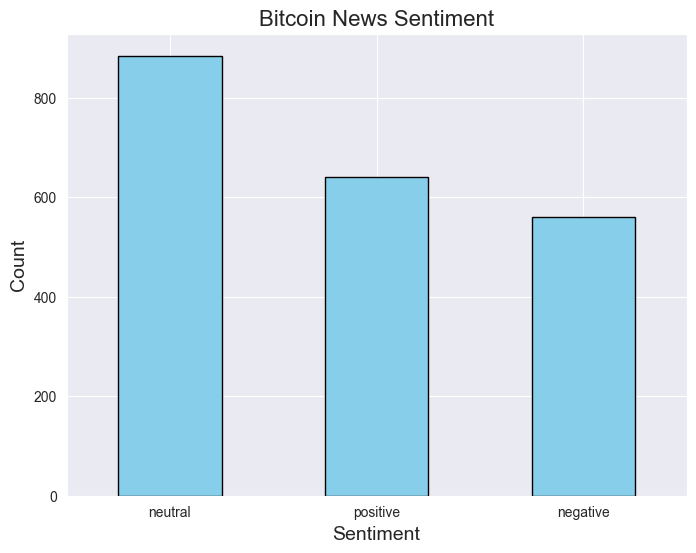

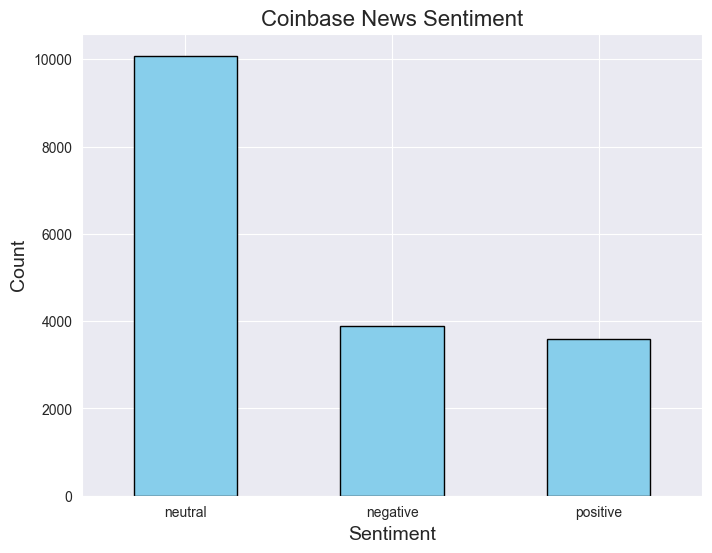

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("darkgrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the Bitcoin News Sentiment
bitcoin_news["label"].value_counts().plot(
    kind="bar", ax=ax, color="skyblue", edgecolor="black"
)
plt.title("Bitcoin News Sentiment", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0)
plt.show()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the Coinbase News Sentiment
coinbase_news["label"].value_counts().plot(
    kind="bar", ax=ax, color="skyblue", edgecolor="black"
)
plt.title("Coinbase News Sentiment", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0)
plt.show()

/Users/rakeenrouf/Flamingo-ML/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


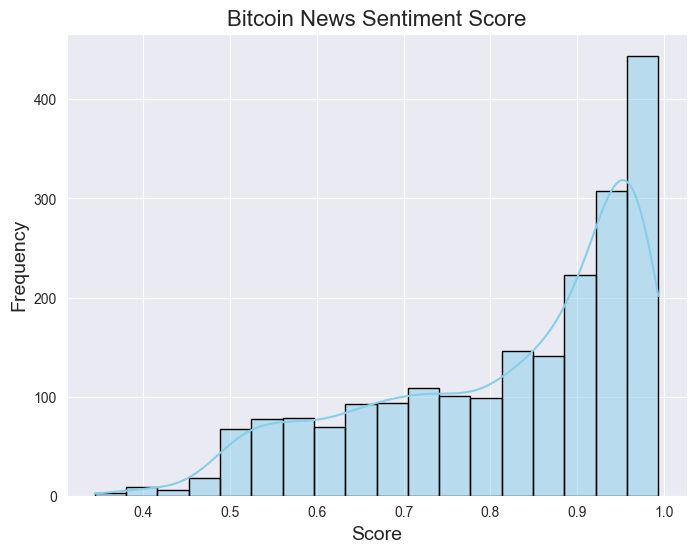

/Users/rakeenrouf/Flamingo-ML/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


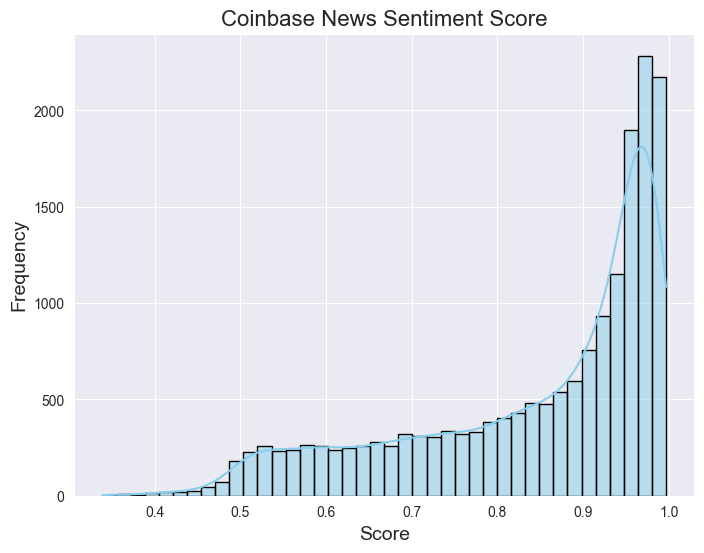

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("darkgrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the Bitcoin News Sentiment Score
sns.histplot(bitcoin_news["score"], kde=True, color="skyblue", edgecolor="black", ax=ax)
plt.title("Bitcoin News Sentiment Score", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the Coinbase News Sentiment Score
sns.histplot(
    coinbase_news["score"], kde=True, color="skyblue", edgecolor="black", ax=ax
)
plt.title("Coinbase News Sentiment Score", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

In [62]:
# convert the Date column to datetime
bitcoin_news["Date"] = pd.to_datetime(bitcoin_news["Date"])
coinbase_news["Date"] = pd.to_datetime(coinbase_news["Date"])

# make a new column 'date' and only keep the day from the 'Date' column
bitcoin_news["date_dt"] = bitcoin_news["Date"].dt.date
bitcoin_news["date_hr"] = bitcoin_news["Date"].dt.hour

coinbase_news["date_dt"] = coinbase_news["Date"].dt.date
coinbase_news["date_hr"] = coinbase_news["Date"].dt.hour

bitcoin_news.head()

,Date,ID,News,label,score,combined_label,date_dt,date_hr
0,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1,2021-04-14,1
1,2021-04-14 07:27:48,33805259.0,<s> bitcoin is not at its bull market top if m...,neutral,0.959562,0,2021-04-14,7
2,2021-04-14 08:21:39,33807018.0,<s> gold futures edge lower on wednesday as ma...,neutral,0.586960,0,2021-04-14,8
3,2021-04-14 08:31:39,33807426.0,<s> open interest on bitcoin futures across th...,positive,0.958578,1,2021-04-14,8
4,2021-04-14 09:26:18,33809664.0,<s> btbt stock is gaining on wednesday ahead o...,positive,0.917841,1,2021-04-14,9


In [63]:
coinbase_news.head()

,Date,ID,News,label,score,combined_label,date_dt,date_hr
0,2021-04-13 22:38:36,33797816.0,"<s> cryptocurrency exchange coinbase global, i...",neutral,0.976008,0,2021-04-13,22
1,2021-04-13 23:17:50,33798186.0,<s> it's fetching $600 on ftx's pre-trade mark...,neutral,0.620525,0,2021-04-13,23
2,2021-04-13 23:32:11,33798375.0,<s> coin could give another boost to the tech ...,positive,0.757015,1,2021-04-13,23
3,2021-04-14 01:15:37,33799410.0,<s> bitcoin pushes to fresh record high after ...,positive,0.909999,1,2021-04-14,1
4,2021-04-14 01:21:44,33799527.0,<s> the market capitalization of cryptocurrenc...,positive,0.550073,1,2021-04-14,1


In [64]:
def get_news_count(df, label):
    news_count = (
        df[df["label"] == label]
        .groupby(["date_dt", "date_hr"])
        .count()["News"]
        .reset_index()
    )
    news_count.columns = ["date_dt", "date_hr", f"{label}_count"]
    return news_count


# function to get average sentiment score
def get_avg_sentiment(df, label):
    avg_sentiment = (
        df[df["label"] == label]
        .groupby(["date_dt", "date_hr"])["score"]
        .mean()
        .reset_index()
    )
    avg_sentiment.columns = ["date_dt", "date_hr", f"{label}_avg_score"]
    return avg_sentiment


# Get the news count for each label
pn = get_news_count(bitcoin_news, "positive")
nn = get_news_count(bitcoin_news, "negative")
neun = get_news_count(bitcoin_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment(bitcoin_news, "positive")
nn_avg = get_avg_sentiment(bitcoin_news, "negative")
neun_avg = get_avg_sentiment(bitcoin_news, "neutral")

# Merge the dataframes
merged = pd.merge(pn, nn, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, neun, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, pn_avg, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, nn_avg, on=["date_dt", "date_hr"], how="outer")
merged = pd.merge(merged, neun_avg, on=["date_dt", "date_hr"], how="outer")

# Fill NaN values with 0
merged = merged.fillna(0)

# total news count
merged["total_news_count"] = (
    merged["positive_count"] + merged["negative_count"] + merged["neutral_count"]
)

merged["total_news_score"] = (
    merged["positive_avg_score"] * merged["positive_count"]
) - (merged["negative_avg_score"] * merged["negative_count"])

merged["signal"] = (merged["positive_count"] - merged["negative_count"]) / (
    merged["positive_count"] + merged["negative_count"]
)

merged.head(15)

,date_dt,date_hr,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-14,1,1.0,0.0,0.0,0.909999,0.000000,0.000000,1.0,0.909999,1.0
1,2021-04-14,7,0.0,0.0,1.0,0.000000,0.000000,0.959562,1.0,0.000000,NaN
2,2021-04-14,8,1.0,0.0,1.0,0.958578,0.000000,0.586960,2.0,0.958578,1.0
3,2021-04-14,9,2.0,0.0,0.0,0.916790,0.000000,0.000000,2.0,1.833581,1.0
4,2021-04-14,10,0.0,0.0,1.0,0.000000,0.000000,0.974475,1.0,0.000000,NaN
5,2021-04-14,11,0.0,1.0,0.0,0.000000,0.937877,0.000000,1.0,-0.937877,-1.0
6,2021-04-14,12,3.0,0.0,0.0,0.881500,0.000000,0.000000,3.0,2.644499,1.0
7,2021-04-14,13,1.0,0.0,3.0,0.990537,0.000000,0.839594,4.0,0.990537,1.0
8,2021-04-14,15,1.0,0.0,0.0,0.853826,0.000000,0.000000,1.0,0.853826,1.0
9,2021-04-14,16,0.0,0.0,1.0,0.000000,0.000000,0.945435,1.0,0.000000,NaN


In [65]:
# Get the news count for each label
pn = get_news_count(coinbase_news, "positive")
nn = get_news_count(coinbase_news, "negative")
neun = get_news_count(coinbase_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment(coinbase_news, "positive")
nn_avg = get_avg_sentiment(coinbase_news, "negative")
neun_avg = get_avg_sentiment(coinbase_news, "neutral")

# Merge the dataframes
merged_c = pd.merge(pn, nn, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, neun, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, pn_avg, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, nn_avg, on=["date_dt", "date_hr"], how="outer")
merged_c = pd.merge(merged_c, neun_avg, on=["date_dt", "date_hr"], how="outer")

# Fill NaN values with 0
merged_c = merged_c.fillna(0)

# total news count
merged_c["total_news_count"] = (
    merged_c["positive_count"] + merged_c["negative_count"] + merged_c["neutral_count"]
)

merged_c["total_news_score"] = (
    merged_c["positive_avg_score"] * merged_c["positive_count"]
) - (merged_c["negative_avg_score"] * merged_c["negative_count"])


merged_c["signal"] = (merged_c["positive_count"] - merged_c["negative_count"]) / (
    merged_c["positive_count"] + merged_c["negative_count"]
)

merged_c.head(15)

,date_dt,date_hr,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-13,22,0.0,0.0,1.0,0.000000,0.000000,0.976008,1.0,0.000000,NaN
1,2021-04-13,23,1.0,0.0,1.0,0.757015,0.000000,0.620525,2.0,0.757015,1.000000
2,2021-04-14,1,2.0,0.0,1.0,0.730036,0.000000,0.955020,3.0,1.460072,1.000000
3,2021-04-14,2,1.0,0.0,0.0,0.731785,0.000000,0.000000,1.0,0.731785,1.000000
4,2021-04-14,3,0.0,0.0,1.0,0.000000,0.000000,0.557790,1.0,0.000000,NaN
5,2021-04-14,4,0.0,1.0,2.0,0.000000,0.582914,0.830418,3.0,-0.582914,-1.000000
6,2021-04-14,5,0.0,1.0,2.0,0.000000,0.784684,0.828336,3.0,-0.784684,-1.000000
7,2021-04-14,6,1.0,0.0,5.0,0.512273,0.000000,0.822194,6.0,0.512273,1.000000
8,2021-04-14,7,0.0,1.0,5.0,0.000000,0.953189,0.892880,6.0,-0.953189,-1.000000
9,2021-04-14,8,5.0,0.0,3.0,0.813772,0.000000,0.806942,8.0,4.068859,1.000000


In [66]:
# save the data
merged.to_csv(r"../crypto_news/bitcoin_news_sentiment_hourly.csv")
merged_c.to_csv(r"../crypto_news/coinbase_news_sentiment_hourly.csv")

<Figure size 1000x800 with 0 Axes>

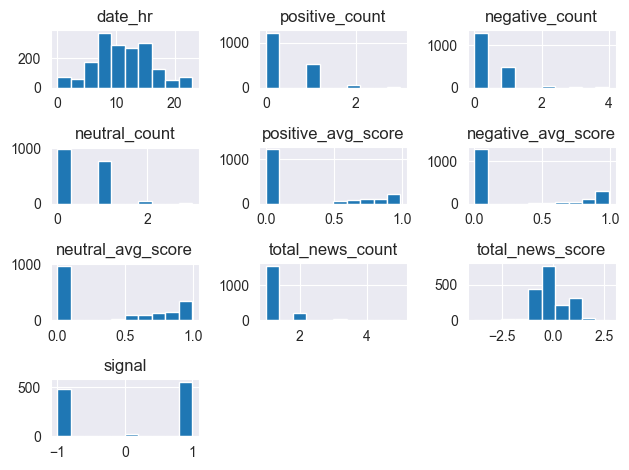

In [91]:
# see distributions of each column other than date_dt and date_hr
plt.figure(figsize=(10, 8))  # Set the figure size
merged.hist()
plt.tight_layout()
plt.show()

In [68]:
def get_news_count_d(df, label):
    news_count = (
        df[df["label"] == label].groupby(["date_dt"]).count()["News"].reset_index()
    )
    news_count.columns = ["date_dt", f"{label}_count"]
    return news_count


# function to get average sentiment score
def get_avg_sentiment_d(df, label):
    avg_sentiment = (
        df[df["label"] == label].groupby(["date_dt"])["score"].mean().reset_index()
    )
    avg_sentiment.columns = ["date_dt", f"{label}_avg_score"]
    return avg_sentiment


# Get the news count for each label
pn = get_news_count_d(bitcoin_news, "positive")
nn = get_news_count_d(bitcoin_news, "negative")
neun = get_news_count_d(bitcoin_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment_d(bitcoin_news, "positive")
nn_avg = get_avg_sentiment_d(bitcoin_news, "negative")
neun_avg = get_avg_sentiment_d(bitcoin_news, "neutral")

# Merge the dataframes
merged_d = pd.merge(pn, nn, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, neun, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, pn_avg, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, nn_avg, on="date_dt", how="outer")
merged_d = pd.merge(merged_d, neun_avg, on="date_dt", how="outer")

# Fill NaN values with 0
merged_d = merged_d.fillna(0)

# total news count
merged_d["total_news_count"] = (
    merged_d["positive_count"] + merged_d["negative_count"] + merged_d["neutral_count"]
)

merged_d["total_news_score"] = (
    merged_d["positive_avg_score"] * merged_d["positive_count"]
) - (merged_d["negative_avg_score"] * merged_d["negative_count"])

merged_d["signal"] = (merged_d["positive_count"] - merged_d["negative_count"]) / (
    merged_d["positive_count"] + merged_d["negative_count"]
)

merged_d.head(15)

,date_dt,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-14,10.0,2.0,10.0,0.907243,0.959677,0.849137,22.0,7.153077,0.666667
1,2021-04-15,6.0,10.0,7.0,0.623001,0.895473,0.726584,23.0,-5.216729,-0.250000
2,2021-04-16,1.0,2.0,3.0,0.725935,0.804262,0.818327,6.0,-0.882590,-0.333333
3,2021-04-17,0.0,0.0,3.0,0.000000,0.000000,0.674051,3.0,0.000000,NaN
4,2021-04-18,2.0,6.0,1.0,0.886130,0.962285,0.899825,9.0,-4.001451,-0.500000
5,2021-04-19,3.0,5.0,2.0,0.867508,0.785641,0.786232,10.0,-1.325679,-0.250000
6,2021-04-20,3.0,3.0,1.0,0.722198,0.895534,0.726418,7.0,-0.520008,0.000000
7,2021-04-21,1.0,1.0,5.0,0.642198,0.476258,0.731610,7.0,0.165941,0.000000
8,2021-04-22,0.0,0.0,2.0,0.000000,0.000000,0.731999,2.0,0.000000,NaN
9,2021-04-23,1.0,11.0,3.0,0.586267,0.906848,0.899653,15.0,-9.389061,-0.833333


In [69]:
# Get the news count for each label
pn = get_news_count_d(coinbase_news, "positive")
nn = get_news_count_d(coinbase_news, "negative")
neun = get_news_count_d(coinbase_news, "neutral")

# Get the average sentiment score for each label
pn_avg = get_avg_sentiment_d(coinbase_news, "positive")
nn_avg = get_avg_sentiment_d(coinbase_news, "negative")
neun_avg = get_avg_sentiment_d(coinbase_news, "neutral")

# Merge the dataframes
merged_dc = pd.merge(pn, nn, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, neun, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, pn_avg, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, nn_avg, on="date_dt", how="outer")
merged_dc = pd.merge(merged_dc, neun_avg, on="date_dt", how="outer")

# Fill NaN values with 0
merged_dc = merged_dc.fillna(0)

# total news count
merged_dc["total_news_count"] = (
    merged_dc["positive_count"]
    + merged_dc["negative_count"]
    + merged_dc["neutral_count"]
)

merged_dc["total_news_score"] = (
    merged_dc["positive_avg_score"] * merged_dc["positive_count"]
) - (merged_dc["negative_avg_score"] * merged_dc["negative_count"])


merged_dc["signal"] = (merged_dc["positive_count"] - merged_dc["negative_count"]) / (
    merged_dc["positive_count"] + merged_dc["negative_count"]
)

merged_dc.head(5)

,date_dt,positive_count,negative_count,neutral_count,positive_avg_score,negative_avg_score,neutral_avg_score,total_news_count,total_news_score,signal
0,2021-04-13,1.0,0.0,2.0,0.757015,0.000000,0.798267,3.0,0.757015,1.000000
1,2021-04-14,44.0,23.0,94.0,0.786364,0.817363,0.884039,161.0,15.800687,0.313433
2,2021-04-15,51.0,28.0,73.0,0.823400,0.890134,0.858108,152.0,17.069669,0.291139
3,2021-04-16,14.0,12.0,44.0,0.794744,0.798550,0.832263,70.0,1.543818,0.076923
4,2021-04-17,3.0,2.0,9.0,0.662382,0.733936,0.782948,14.0,0.519273,0.200000


In [70]:
# save the data
merged_d.to_csv(r"../crypto_news/bitcoin_news_sentiment_daily.csv")
merged_dc.to_csv(r"../crypto_news/coinbase_news_sentiment_daily.csv")

### Lag the news for 1 day

In [79]:
merged_dc.set_index("date_dt", inplace=True)
merged_d.set_index("date_dt", inplace=True)

merged_d_lag1 = merged_d.shift(1).dropna()
merged_dc_lag1 = merged_dc.shift(1).dropna()

In [83]:
merged_d_lag1.to_csv("../Data/bitcoin_news_sentiment_daily_lag1.csv")
merged_dc_lag1.to_csv("../Data/coinbase_news_sentiment_daily_lag1.csv")